# <center> <img src="../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> **Big Data** </center>
---
### <center> **Autumn 2025** </center>
---
### <center> **Examples on Machine Learning: Decision Trees and Random Forest** </center>
---
**Profesor**: Pablo Camarillo Ramirez

# Create SparkSession

In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ML: Decision Trees & Random Forest") \
    .master("spark://spark-master:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

# Decision Trees
## Collect Data

In [ ]:
from pcamarillor.spark_utils import SparkUtils
# Create a small dataset as a list of tuples
# Format: (label, x1, x2)
data = [
      (0, 1.0, 0.5),
      (1, 2.0, 1.5),
      (0, 1.5, 0.2),
      (1, 2.2, 1.0),
      (0, 1.0, -0.3),
      (1, 2.5, 1.0)
]

# Define schema for the DataFrame
schema = SparkUtils.generate_schema([("label", "int"), ("x1", "float"), ("x2", "float")])

# Convert list to a DataFrame
df = spark.createDataFrame(data, schema)

### Assemble the features into a single vector column

In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["x1", "x2"], outputCol="features")
data_with_features = assembler.transform(df).select("label", "features")                               

## Data splitting
### 80% training data and 20% testing data

In [ ]:
train_df, test_df = data_with_features.randomSplit([0.8, 0.2], seed=57)

### Show dataset (for debugging)

In [ ]:
print("Original Dataset")
df.show()

# Print train dataset
print("train set")
train_df.show()

## Create ML Model

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

# Initialize and train the Decision Tree model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

## Train ML Model

In [ ]:
dt_model = dt.fit(train_df)

# Display model summary
print("Decision Tree model summary:{0}".format(dt_model.toDebugString))

## Persist the model

In [ ]:
model_path = "/opt/spark/work-dir/data/mlmodels/dt/dt1"
dt_model.write().overwrite().save(model_path)

## Predictions

In [ ]:
# Use the trained model to make predictions on the test data
predictions = dt_model.transform(test_df)

# Show predictions
predictions.select("features", "prediction").show()

In [ ]:
from pyspark.ml.classification import DecisionTreeClassificationModel

# Retreive the saved model
saved_dt_model = DecisionTreeClassificationModel.load(model_path)

# Use the trained model to make predictions on the test data
predictions = saved_dt_model.transform(test_df)

# Show predictions
predictions.select("features", "prediction").show()

## Test ML Model

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label",
                            predictionCol="prediction")

accuracy = evaluator.evaluate(predictions, 
                  {evaluator.metricName: "accuracy"})
print(f"Accuracy: {accuracy}")

f1 = evaluator.evaluate(predictions,
                {evaluator.metricName: "f1"})
print(f"F1 Score: {f1}")  

# Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Train the model
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=100,
    maxDepth=5,
    seed=42
)

rf_model = rf.fit(train_df)

# Save the model
rf_path = "/opt/spark/work-dir/data/mlmodels/rf/rf1"
rf_model.write().overwrite().save(rf_path)
print(f"Random forest model generated: {rf_model.toDebugString}")

In [ ]:
from pyspark.ml.classification import RandomForestClassificationModel
# Read the RF model
rf_model_saved = rf_model.load(rf_path)

# Make predictions on test data
predictions_rf = rf_model_saved.transform(test_df)

evaluator = MulticlassClassificationEvaluator(labelCol="label",
                            predictionCol="prediction")

accuracy_rf = evaluator.evaluate(predictions_rf, 
                  {evaluator.metricName: "accuracy"})
print(f"Accuracy of Random Forest: {accuracy}")

f1_rf = evaluator.evaluate(predictions_rf,
                {evaluator.metricName: "f1"})
print(f"F1 Score of Random Forest: {f1}") 

# Lab 12: Classifying Iris Dataset

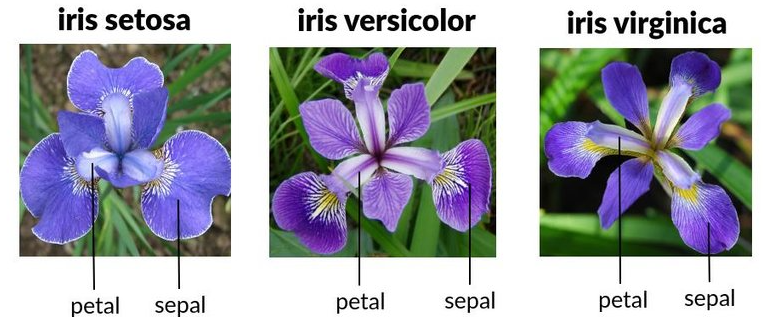

# Data collection

In [ ]:
# Define schema for the DataFrame

iris_schema = SparkUtils.generate_schema([
    ("Id", "int"), 
    ("SepalLengthCm", "float"), 
    ("SepalWidthCm", "float"), 
    ("PetalLengthCm", "float"), 
    ("PetalWidthCm", "float"), 
    ("Species", "string")])

# Source: https://raw.githubusercontent.com/selva86/datasets/master/Iris.csv

iris_df = spark.read \
                .option("header", "true") \
                .schema(iris_schema) \
                .csv("/opt/spark/work-dir/data/ml/decision_trees/")

iris_df.printSchema()
iris_df.show(5)


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

feature_cols = ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]

# Convert string labels (species) to numeric
label_indexer = StringIndexer(inputCol="Species", outputCol="label")

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Define the Random Forest model
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=100,
    maxDepth=5,
    seed=42
)

# Build a pipeline
pipeline = Pipeline(stages=[label_indexer, assembler, rf])

# Split the data into training and test sets
train_df, test_df = iris_df.randomSplit([0.8, 0.2], seed=42)

# Train the model
model = pipeline.fit(train_df)

# Make predictions on test data
predictions = model.transform(test_df)
predictions.show()


## Decision Trees

### Data Splitting

### Create ML Model

### Train ML Model

### Persist ML Model

### Test ML Model

## Random Forest

### Data Splitting

### Create ML Model

### Train ML Model

### Persist ML Model

### Test ML Model

## Compare Decision Trees vs Random Forest

In [ ]:
sc.stop()